<h1 style="text-align:center; color:green; font-size:48px;">
Step 1: Base Heating Network
</h1>

#### Install libraries (if you did not do it before on the terminal)

In [1]:
# !pip install numpy==2.0.2 pandas==2.3.1
# !pip install matplotlib
# !pip install git+https://github.com/oemof/dhnx.git@dev
# !pip install osmnx==1.9.4 oemof.solph==0.5.6

# Import libraries

In [2]:
import matplotlib.pyplot as plt
import dhnx
import pandas as pd
import oemof.solph
from pyomo.environ import SolverFactory


## 1.1 Create network and plot

In [41]:
# Initialize thermal network
network = dhnx.network.ThermalNetwork()

# Load town parameter
network = network.from_csv_folder(r"STEP_1/twn_data")
    
# Load investment parameter
invest_opt = dhnx.input_output.load_invest_options(r"STEP_1/invest_data")

No sequences found to create timeindex from


In [42]:
print(network)

dhnx.network.ThermalNetwork object with these components
 * 2 producers
 * 5 consumers
 * 5 forks
 * 14 pipes



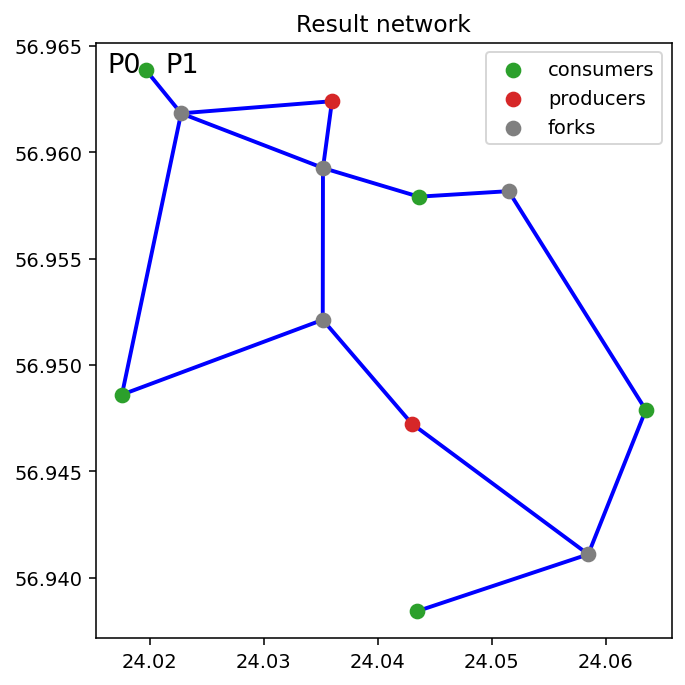

In [43]:
# plot invested edges
plt.rcParams['figure.figsize'] = (10, 8)   # <-- bigger
plt.rcParams['figure.dpi'] = 140

static_map_1 = dhnx.plotting.StaticMap(network)
static_map_1.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network')

# Scatter points
plt.scatter(network.components.consumers['lon'], network.components.consumers['lat'],
            color='tab:green', label='consumers', zorder=2.5, s=50)
plt.scatter(network.components.producers['lon'], network.components.producers['lat'],
            color='tab:red', label='producers', zorder=2.5, s=50)
plt.scatter(network.components.forks['lon'], network.components.forks['lat'],
            color='tab:grey', label='forks', zorder=2.5, s=50)

# labels that DON'T expand the axis extent
plt.text(0.02, 0.95, 'P0', transform=ax.transAxes, fontsize=14)
plt.text(0.12, 0.95, 'P1', transform=ax.transAxes, fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()

## 1.2 Investment optimization of the network

In [44]:
# Optimize the investment data
network.optimize_investment(invest_options=invest_opt,  solver='glpk')


INFO:dhnx.optimization.optimization_models:Initialize the energy system
INFO:dhnx.optimization.optimization_models:Create oemof objects
INFO:dhnx.optimization.optimization_models:Producers, Consumers Nodes appended.
c:\Users\irfan\anaconda3\envs\env_P2\lib\site-packages\oemof\solph\flows\_flow.py:163: FutureWarning: For backward compatibility, the option investment overwrites the option nominal_value. Both options cannot be set at the same time.
  warn(msg, FutureWarning)
c:\Users\irfan\anaconda3\envs\env_P2\lib\site-packages\oemof\network\network\nodes.py:250: FutureWarning: Usage of oemof.network.Component is deprecated. Use oemof.network.Node instead.
  warnings.warn(
INFO:dhnx.optimization.optimization_models:DHS Nodes appended.
INFO:dhnx.optimization.optimization_models:Energysystem has been created
INFO:dhnx.optimization.optimization_models:Build the operational model


INFO:dhnx.optimization.optimization_models:Solve the optimization problem


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\irfan\AppData\Local\Temp\tmpkez4pf2t.glpk.raw --wglp C:\Users\irfan\AppData\Local\Temp\tmpjplpvujj.glpk.glp
 --cpxlp C:\Users\irfan\AppData\Local\Temp\tmp94swt5lm.pyomo.lp
Reading problem data from 'C:\Users\irfan\AppData\Local\Temp\tmp94swt5lm.pyomo.lp'...
C:\Users\irfan\AppData\Local\Temp\tmp94swt5lm.pyomo.lp:1842: warning: lower bound of variable 'x34' redefined
C:\Users\irfan\AppData\Local\Temp\tmp94swt5lm.pyomo.lp:1842: warning: upper bound of variable 'x34' redefined
300 rows, 258 columns, 610 non-zeros
32 integer variables, all of which are binary
1874 lines were read
Writing problem data to 'C:\Users\irfan\AppData\Local\Temp\tmpjplpvujj.glpk.glp'...
1594 lines were written
GLPK Integer Optimizer 5.0
300 rows, 258 columns, 610 non-zeros
32 integer variables, all of which are binary
Preprocessing...
209 rows, 204 columns, 448 non-zeros
32 integer variables, all of which are binary
Scaling

INFO:root:Optimization successful...


## 1.3 Results postprocessing and Plotting 


In [45]:
# ####### Postprocessing and Plotting ###########
results_edges = network.results.optimization['components']['pipes']
print(results_edges[['from_node', 'to_node', 'hp_type', 'capacity',
                     'direction', 'costs', 'losses']])

results_edges.to_csv("STEP_1/Outputs/Optimum_network_base.csv", index=True)

print('Objective value: ', network.results.optimization['oemof_meta']['objective'])

# assign new ThermalNetwork with invested pipes
twn_results = network
twn_results.components['pipes'] = results_edges[results_edges['capacity'] > 0.001]



      from_node      to_node hp_type  capacity  direction        costs  losses
id                                                                            
0       forks-1  consumers-0   DN-25    905.49          1   53592.8162     0.0
1   producers-1      forks-1   DN-25    905.49          1  145763.7664     0.0
2   producers-1      forks-0   DN-25    308.00          1   22591.7406     0.0
3       forks-1      forks-0    None      0.00          0       0.0000     0.0
4       forks-1  consumers-1    None      0.00          0       0.0000     0.0
5       forks-0      forks-3    None      0.00          0       0.0000     0.0
6       forks-0  consumers-2   DN-25    308.00          1   36883.2672     0.0
7       forks-4  consumers-2    None      0.00          0       0.0000     0.0
8       forks-4  consumers-3    None      0.00          0       0.0000     0.0
9       forks-3  producers-0   DN-25   1424.30         -1  165634.9296     0.0
10  producers-0      forks-2   DN-25   2790.18      

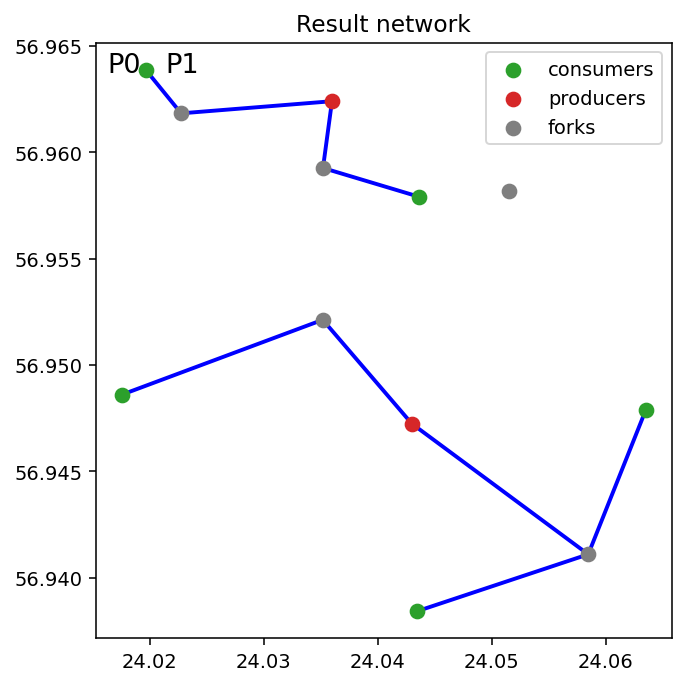

In [46]:
# plot invested edges
plt.rcParams['figure.figsize'] = (10, 8)   # <-- bigger
plt.rcParams['figure.dpi'] = 140

static_map_2 = dhnx.plotting.StaticMap(twn_results)
static_map_2.draw(background_map=False)
ax = plt.gca()
ax.set_title('Result network')

# Scatter points
plt.scatter(network.components.consumers['lon'], network.components.consumers['lat'],
            color='tab:green', label='consumers', zorder=2.5, s=50)
plt.scatter(network.components.producers['lon'], network.components.producers['lat'],
            color='tab:red', label='producers', zorder=2.5, s=50)
plt.scatter(network.components.forks['lon'], network.components.forks['lat'],
            color='tab:grey', label='forks', zorder=2.5, s=50)

# labels that DON'T expand the axis extent
plt.text(0.02, 0.95, 'P0', transform=ax.transAxes, fontsize=14)
plt.text(0.12, 0.95, 'P1', transform=ax.transAxes, fontsize=14)

plt.legend()
plt.tight_layout()
plt.show()